In [1]:
import os

In [2]:
TOP = os.getcwd().replace('notebooks','')
processed_dir = TOP + 'data/processed/'
external_dir = TOP + 'data/external/'
interim_dir = TOP + 'data/interim/'
figures_dir = TOP + 'reports/figures/'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
%matplotlib inline

In [4]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors


In [5]:
import glob

In [45]:
vega = pd.read_csv(external_dir+'vega_110624.csv', index_col = [0])

In [46]:
len([e for e in vega.columns if 'assessment' in e])

33

In [47]:
models = [e for e in vega.columns if 'assessment' in e]

In [48]:
models

['Mutagenicity (Ames test) CONSENSUS model-assessment',
 'Developmental Toxicity model (CAESAR)-assessment',
 'Developmental/Reproductive Toxicity library (PG)-assessment',
 'Carcinogenicity model (CAESAR)-assessment',
 'Carcinogenicity model (ISS)-assessment',
 'Carcinogenicity model (IRFMN-ISSCAN-CGX)-assessment',
 'Carcinogenicity model (IRFMN-Antares)-assessment',
 'Carcinogenicity oral classification model (IRFMN)-assessment',
 'Carcinogenicity oral Slope Factor model (IRFMN)-assessment',
 'Carcinogenicity inhalation classification model (IRFMN)-assessment',
 'Carcinogenicity inhalation Slope Factor model (IRFMN)-assessment',
 'Carcinogenicity in male rat (CORAL)-assessment',
 'Carcinogenicity in female Rat (CORAL)-assessment',
 'Acute Toxicity (LD50) model (KNN)-assessment',
 'Skin Sensitization model (CAESAR)-assessment',
 'Skin Sensitization model (IRFMN-JRC)-assessment',
 'Skin Sensitization model (NCSTOX)-assessment',
 'Skin Sensitization model (TOXTREE)-assessment',
 'Skin S

In [49]:
vega = vega.set_index('dtxsid')

In [59]:
cols_del = []
for e in vega[models]:
    if  ('mg/kg' in e) or ('mmol/kg'  in e) or ('Slope'  in e) or ('CORAL'  in e):
        cols_del.append(e)
     

In [60]:
cols_del = ['Carcinogenicity oral Slope Factor model (IRFMN)-assessment',
 'Carcinogenicity inhalation Slope Factor model (IRFMN)-assessment',
 'Carcinogenicity in male rat (CORAL)-assessment',
 'Carcinogenicity in female Rat (CORAL)-assessment',
 'NOAEL (IRFMN-CORAL)-assessment',
            'NOAEL (CONCERT/Coral)-assessment',
            'Acute Toxicity (LD50) model (KNN)-assessment',
 'Liver NOAEL (CORAL)-assessment']



In [61]:
vega1 = vega[[col for col in models if col  not in cols_del]]

In [62]:
vega1.columns

Index(['Mutagenicity (Ames test) CONSENSUS model-assessment',
       'Developmental Toxicity model (CAESAR)-assessment',
       'Developmental/Reproductive Toxicity library (PG)-assessment',
       'Carcinogenicity model (CAESAR)-assessment',
       'Carcinogenicity model (ISS)-assessment',
       'Carcinogenicity model (IRFMN-ISSCAN-CGX)-assessment',
       'Carcinogenicity model (IRFMN-Antares)-assessment',
       'Carcinogenicity oral classification model (IRFMN)-assessment',
       'Carcinogenicity inhalation classification model (IRFMN)-assessment',
       'Skin Sensitization model (CAESAR)-assessment',
       'Skin Sensitization model (IRFMN-JRC)-assessment',
       'Skin Sensitization model (NCSTOX)-assessment',
       'Skin Sensitization model (TOXTREE)-assessment',
       'Skin Sensitization (CONCERT/Kode)-assessment',
       'Skin Sensitization (CONCERT/SarPy)-assessment',
       'Skin Irritation (CONCERT/Kode)-assessment',
       'Skin Irritation (CONCERT/Coral)-assessment',

In [77]:
vega1 = (vega1
    .assign(ames_mutagenicity  = vega1['Mutagenicity (Ames test) CONSENSUS model-assessment'].str.replace(r'\s*\(Consensus score:[^)]+\)', '', regex=True))
 .drop(['Mutagenicity (Ames test) CONSENSUS model-assessment'], axis =1)
)

In [78]:
mappings = []
for col in vega1.columns:
    mappings.append(vega1[col].unique().tolist())

In [79]:
mapping_dict = (list(set([e for i in mappings for e in i])))

In [81]:
#mapping_dict

In [82]:
mapping_dict = {k:v for k,v in zip(mapping_dict, mapping_dict)}

In [124]:
def map_prediction_confidence(cell_value):
    mapping = {
     'Inactive (MODERATE reliability)': -0.5,
     'IRRITANT (MODERATE reliability)': 0.5,
     'NOT IRRITANT (EXPERIMENTAL value)': -1,
     'NON-Irritating (MODERATE reliability)': -0.5,
     'Irritating (MODERATE reliability)': 0.5,
     'IRRITANT (EXPERIMENTAL value)': 1,
     'Toxicant (EXPERIMENTAL value)': 1,
     'Carcinogen (LOW reliability)': 0.25,
     'Toxicant (GOOD reliability)': 0.75,
     'Sensitizer (EXPERIMENTAL value)': 1,
     'SN2-Nucleophilic Aliphatic Substitution': 0.75,
     'No class found': -0.25,
     'NON-Toxicant (MODERATE reliability)': -0.5,
     'Reproductive and developmental NON-toxicant (EXPERIMENTAL value)': -1,
     'Toxicant (MODERATE reliability)': 0.5,
     'NON-Carcinogen (MODERATE reliability)': -0.5,
     'NOT IRRITANT (GOOD reliability)': -0.5,
     'Inactive (GOOD reliability)': -0.75,
     'Unknown': np.nan,
     'Reproductive and developmental toxicant (EXPERIMENTAL value)': 1,
     'Sensitizer (GOOD reliability)': 0.75,
     'Irritating (EXPERIMENTAL value)': 1,
     'NON-genotoxic (LOW reliability)': -0.25,
     'NON-Irritating (GOOD reliability)': -0.75,
     'Genotoxic (EXPERIMENTAL value)': 1,
     'Active (GOOD reliability)': 0.75,
     'Active (EXPERIMENTAL value)': 1,
     'NON-Sensitizer (EXPERIMENTAL value)': -1,
     'Mutagenic': 0.75,
     'Michael Acceptor': 0.75,
     'NON-Toxicant (GOOD reliability)': -0.75,
     'Inactive (EXPERIMENTAL value)': -1,
     'Not Classifiable': 0,
     'NON-Toxicant (EXPERIMENTAL value)': -1,
     'Toxicant (LOW reliability)': 0.25,
     'Reproductive NON-toxicant (no data on developmental toxicity) (EXPERIMENTAL value)': -1,
     'NON-Carcinogen (LOW reliability)':-0.25,
     'Toxic (EXPERIMENTAL value)': 1,
     'Reproductive toxicant, developmental NON-toxicant (EXPERIMENTAL value)': 1,
     'NON-Toxicant (LOW reliability)': -0.25,
     'Irritating (LOW reliability)': 0.25,
     'NON-Sensitizer (GOOD reliability)': -0.75,
     'Possible NON-Carcinogen (MODERATE reliability)': -0.5,
     'Possible NON-Carcinogen (LOW reliability)': -0.25,
     'IRRITANT (LOW reliability)': 0.25,
     'Genotoxic (GOOD reliability)': 0.75,
     'Irritating (GOOD reliability)': 0.75,
     'NON-genotoxic (MODERATE reliability)': -0.5,
     'Genotoxic (LOW reliability)': 0.25,
     'NOT IRRITANT (MODERATE reliability)': -0.5,
     'Developmental NON-toxicant (no data on reproductive toxicity) (EXPERIMENTAL value)': -1,
     'Toxic (GOOD reliability)': 0.75,
     'Non Predicted': np.nan,
     'NON-genotoxic (EXPERIMENTAL value)': -1,
     'NON-Carcinogen (GOOD reliability)': -0.75,
     'Developmental toxicant, reproductive NON-toxicant (EXPERIMENTAL value)':1,
     'Carcinogen (GOOD reliability)': 0.75,
     'NON-Carcinogen (EXPERIMENTAL value)': -1,
     'Toxic (LOW reliability)': 0.25,
     'Acyl Transfer Agents': 0.75,
     'Inactive (LOW reliability)': -0.25,
     'IRRITANT (GOOD reliability)': 0.75,
     'Reproductive toxicant (no data on developmental toxicity) (EXPERIMENTAL value)': 1,
     'NON-genotoxic (GOOD reliability)': -0.75,
     'NON-Toxic (MODERATE reliability)': -0.5,
     'NON-Irritating (EXPERIMENTAL value)': -1,
     'NON-Toxic (LOW reliability)': -0.25,
     'Active (MODERATE reliability)': 0.5,
     'Developmental toxicant (no data on reproductive toxicity) (EXPERIMENTAL value)': 1,
     'Sensitizer (LOW reliability)': 0.25,
     'Genotoxic (MODERATE reliability)': 0.5,
     'Not predicted': np.nan,
     'Toxic (MODERATE reliability)': 0.5,
     'Schiff Base Formation': 0.75,
     '[Error]': np.nan,
     'Active (LOW reliability)': 0.25,
     'Carcinogen (EXPERIMENTAL value)': 1,
     'NOT IRRITANT (LOW reliability)': -0.25,
     'Not predicted (LOW reliability)': -0.25,
     'NON-Sensitizer (MODERATE reliability)': -0.5,
     'NON-Irritating (LOW reliability)': -0.25,
     'Carcinogen (MODERATE reliability)': 0.5,
     'NON-Mutagenic': -0.75,
     'NON-Sensitizer (LOW reliability)': -0.25,
     'SNAr-Nucleophilic Aromatic Substitution': 0.75,
     'NON-Toxic (EXPERIMENTAL value)': -1,
     'Sensitizer (MODERATE reliability)': 0.75,
     'NON-Toxic (GOOD reliability)': -0.75,
     'Possible NON-Carcinogen (GOOD reliability)': -0.75}
    return mapping.get(cell_value, 0)

In [125]:
vega2 = vega1.applymap(map_prediction_confidence)

In [126]:
vega2

,Developmental Toxicity model (CAESAR)-assessment,Developmental/Reproductive Toxicity library (PG)-assessment,Carcinogenicity model (CAESAR)-assessment,Carcinogenicity model (ISS)-assessment,Carcinogenicity model (IRFMN-ISSCAN-CGX)-assessment,Carcinogenicity model (IRFMN-Antares)-assessment,Carcinogenicity oral classification model (IRFMN)-assessment,Carcinogenicity inhalation classification model (IRFMN)-assessment,Skin Sensitization model (CAESAR)-assessment,Skin Sensitization model (IRFMN-JRC)-assessment,...,Skin Irritation (CONCERT/Coral)-assessment,Skin Irritation model (CONCERT/SarPy)-assessment,Eye Irritation (CONCERT/Kode)-assessment,Eye Irritation (CONCERT/KNN)-assessment,Eye Irritation (CONCERT/SarPy)-assessment,Chromosomal aberration model (CORAL)-assessment,In vitro Micronucleus activity (IRFMN-VERMEER)-assessment,In vivo Micronucleus activity (IRFMN)-assessment,Hepatotoxicity model (IRFMN)-assessment,ames_mutagenicity
dtxsid,,,,,,,,,,,,,,,,,,,,,
DTXSID9044617,0.25,-0.25,-0.50,-0.25,-0.25,-0.25,0.25,-0.75,0.25,-0.25,...,0.25,0.00,-0.50,-0.75,NaN,-0.75,-0.50,-0.50,0.25,-0.75
DTXSID40867331,-0.25,-0.25,-0.25,-0.25,0.75,0.50,0.50,0.50,0.25,0.25,...,-0.25,-0.25,-0.25,0.00,-0.25,-0.50,-0.50,-0.50,NaN,-0.75
DTXSID0065199,NaN,-0.25,0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,...,0.25,0.00,-0.25,0.00,NaN,-0.25,-0.25,NaN,NaN,-0.75
DTXSID90881284,-0.25,-0.25,-0.25,0.25,-0.25,0.25,-0.25,0.25,-0.25,-0.25,...,-0.25,-0.25,0.25,0.00,0.25,-0.25,-0.25,-0.25,NaN,0.75
DTXSID1021900,-0.75,0.75,-0.75,-0.25,-0.25,-0.75,0.75,-0.25,0.75,-0.25,...,-0.50,0.00,-0.25,0.00,NaN,-0.75,0.50,-0.50,NaN,-0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID3067314,0.25,0.50,-0.25,-0.50,0.50,0.25,0.50,-0.75,0.25,0.25,...,-0.50,-0.25,-0.25,0.50,-0.25,0.25,-0.50,NaN,NaN,-0.75
DTXSID1063722,0.25,0.75,-0.25,0.50,-0.25,0.50,-0.50,-0.50,-0.50,0.75,...,0.75,0.25,0.25,0.00,NaN,0.50,-0.25,-0.75,NaN,0.75
DTXSID4021975,0.25,-0.25,-0.25,-0.50,0.25,-0.50,-1.00,-1.00,0.25,-0.25,...,-0.75,-0.75,-0.50,-0.75,NaN,0.50,-0.25,-1.00,NaN,-0.75


In [127]:
vega2.to_csv(interim_dir+'vega_weighted_091124.csv')

In [128]:
vega2.columns

Index(['Developmental Toxicity model (CAESAR)-assessment',
       'Developmental/Reproductive Toxicity library (PG)-assessment',
       'Carcinogenicity model (CAESAR)-assessment',
       'Carcinogenicity model (ISS)-assessment',
       'Carcinogenicity model (IRFMN-ISSCAN-CGX)-assessment',
       'Carcinogenicity model (IRFMN-Antares)-assessment',
       'Carcinogenicity oral classification model (IRFMN)-assessment',
       'Carcinogenicity inhalation classification model (IRFMN)-assessment',
       'Skin Sensitization model (CAESAR)-assessment',
       'Skin Sensitization model (IRFMN-JRC)-assessment',
       'Skin Sensitization model (NCSTOX)-assessment',
       'Skin Sensitization model (TOXTREE)-assessment',
       'Skin Sensitization (CONCERT/Kode)-assessment',
       'Skin Sensitization (CONCERT/SarPy)-assessment',
       'Skin Irritation (CONCERT/Kode)-assessment',
       'Skin Irritation (CONCERT/Coral)-assessment',
       'Skin Irritation model (CONCERT/SarPy)-assessment',
  

In [129]:
df = pd.read_excel(interim_dir+'categorisatons_wscreening_constraints_final_picks_080823.xlsx', sheet_name = 'All data', index_col = [0])


In [130]:
df['group_str'].nunique()

180

In [131]:
mydict = {k:v for k,v in zip(df['dtxsid'],df[ 'group_str'])}
selections = {k:v for k,v in zip(df['dtxsid'],df[ 'final_picks']) }

In [170]:
len(vega2.columns)

25

In [171]:
#vega3

In [172]:
vega_1 = (vega2.reset_index()
 .assign(group_str = vega2.reset_index()['dtxsid'].replace(mydict ))
 )

In [173]:
vega_1 = (vega_1.assign(final_picks = vega_1['dtxsid'].replace(selections)))
vega_1

,dtxsid,Developmental Toxicity model (CAESAR)-assessment,Developmental/Reproductive Toxicity library (PG)-assessment,Carcinogenicity model (CAESAR)-assessment,Carcinogenicity model (ISS)-assessment,Carcinogenicity model (IRFMN-ISSCAN-CGX)-assessment,Carcinogenicity model (IRFMN-Antares)-assessment,Carcinogenicity oral classification model (IRFMN)-assessment,Carcinogenicity inhalation classification model (IRFMN)-assessment,Skin Sensitization model (CAESAR)-assessment,...,Eye Irritation (CONCERT/Kode)-assessment,Eye Irritation (CONCERT/KNN)-assessment,Eye Irritation (CONCERT/SarPy)-assessment,Chromosomal aberration model (CORAL)-assessment,In vitro Micronucleus activity (IRFMN-VERMEER)-assessment,In vivo Micronucleus activity (IRFMN)-assessment,Hepatotoxicity model (IRFMN)-assessment,ames_mutagenicity,group_str,final_picks
0,DTXSID9044617,0.25,-0.25,-0.50,-0.25,-0.25,-0.25,0.25,-0.75,0.25,...,-0.50,-0.75,NaN,-0.75,-0.50,-0.50,0.25,-0.75,"('Benzene and substituted derivatives', 6.0)",NaN
1,DTXSID40867331,-0.25,-0.25,-0.25,-0.25,0.75,0.50,0.50,0.50,0.25,...,-0.25,0.00,-0.25,-0.50,-0.50,-0.50,NaN,-0.75,"('Benzene and substituted derivatives', 4.0)",NaN
2,DTXSID0065199,NaN,-0.25,0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,...,-0.25,0.00,NaN,-0.25,-0.25,NaN,NaN,-0.75,"('Mixed metal/non-metal compounds', 5.0)",NaN
3,DTXSID90881284,-0.25,-0.25,-0.25,0.25,-0.25,0.25,-0.25,0.25,-0.25,...,0.25,0.00,0.25,-0.25,-0.25,-0.25,NaN,0.75,"('Carboxylic acids and derivatives', 1.0)",NaN
4,DTXSID1021900,-0.75,0.75,-0.75,-0.25,-0.25,-0.75,0.75,-0.25,0.75,...,-0.25,0.00,NaN,-0.75,0.50,-0.50,NaN,-0.75,"('Diazinanes', nan)",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12923,DTXSID3067314,0.25,0.50,-0.25,-0.50,0.50,0.25,0.50,-0.75,0.25,...,-0.25,0.50,-0.25,0.25,-0.50,NaN,NaN,-0.75,"('Organic phosphoric acids and derivatives', 1.0)",NaN
12924,DTXSID1063722,0.25,0.75,-0.25,0.50,-0.25,0.50,-0.50,-0.50,-0.50,...,0.25,0.00,NaN,0.50,-0.25,-0.75,NaN,0.75,"('Organohalogen compounds', 4.0)",1.0
12925,DTXSID4021975,0.25,-0.25,-0.25,-0.50,0.25,-0.50,-1.00,-1.00,0.25,...,-0.50,-0.75,NaN,0.50,-0.25,-1.00,NaN,-0.75,"('Benzene and substituted derivatives', 2.0)",NaN
12926,DTXSID2060125,0.25,-0.25,-0.75,-0.50,-0.50,-0.75,-0.25,0.25,0.25,...,-0.50,0.00,-0.75,-0.50,-0.75,-0.50,NaN,-0.75,"('Organooxygen compounds', 5.0)",NaN


In [174]:
vega_1.final_picks.value_counts()

1.0    297
Name: final_picks, dtype: int64

In [175]:
(vega_1
 .where(lambda x: x.final_picks ==1)
.dropna(subset = 'final_picks')
)

,dtxsid,Developmental Toxicity model (CAESAR)-assessment,Developmental/Reproductive Toxicity library (PG)-assessment,Carcinogenicity model (CAESAR)-assessment,Carcinogenicity model (ISS)-assessment,Carcinogenicity model (IRFMN-ISSCAN-CGX)-assessment,Carcinogenicity model (IRFMN-Antares)-assessment,Carcinogenicity oral classification model (IRFMN)-assessment,Carcinogenicity inhalation classification model (IRFMN)-assessment,Skin Sensitization model (CAESAR)-assessment,...,Eye Irritation (CONCERT/Kode)-assessment,Eye Irritation (CONCERT/KNN)-assessment,Eye Irritation (CONCERT/SarPy)-assessment,Chromosomal aberration model (CORAL)-assessment,In vitro Micronucleus activity (IRFMN-VERMEER)-assessment,In vivo Micronucleus activity (IRFMN)-assessment,Hepatotoxicity model (IRFMN)-assessment,ames_mutagenicity,group_str,final_picks
4,DTXSID1021900,-0.75,0.75,-0.75,-0.25,-0.25,-0.75,0.75,-0.25,0.75,...,-0.25,0.0,NaN,-0.75,0.50,-0.50,NaN,-0.75,"('Diazinanes', nan)",1.0
90,DTXSID7020188,0.75,-0.25,1.00,1.00,1.00,1.00,1.00,1.00,0.25,...,0.25,0.0,-0.50,1.00,0.75,-1.00,NaN,0.75,"('Anthracenes', 9.0)",1.0
141,DTXSID1063516,0.75,-0.25,0.50,0.50,0.75,0.25,-0.25,0.50,-0.25,...,-0.50,0.0,-0.50,-0.25,0.50,-0.50,NaN,0.75,"('Indoles and derivatives', nan)",1.0
166,DTXSID6060264,-0.25,-0.25,-0.25,-0.25,-0.25,-0.50,-0.75,-0.75,0.25,...,-0.50,0.0,0.25,-0.75,-0.50,-0.50,NaN,-0.75,"('Organosulfur compounds', 4.0)",1.0
206,DTXSID20888701,-0.75,-0.25,-0.50,-0.25,0.75,0.50,-0.50,-0.75,0.25,...,-0.50,0.0,-0.50,0.50,0.50,-0.75,0.75,-0.75,"('Pyridines and derivatives', 2.0)",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12579,DTXSID5044942,0.25,-0.25,-0.25,0.50,-0.25,0.25,0.25,-0.50,-0.25,...,-0.50,0.0,NaN,0.25,-0.25,-0.50,NaN,0.75,"('Benzene and substituted derivatives', 6.0)",1.0
12689,DTXSID5062188,0.25,-0.25,-0.50,-0.50,0.50,-0.75,0.75,-0.50,0.25,...,0.50,0.0,-0.50,-0.75,0.75,0.50,0.25,-0.75,"('Pyridines and derivatives', 3.0)",1.0
12724,DTXSID8047503,0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.25,-0.75,0.25,...,-1.00,-1.0,-1.00,-0.50,-0.50,-0.50,0.75,-0.75,"('Glycerolipids', nan)",1.0
12874,DTXSID5063520,-0.25,-0.25,0.25,0.50,-0.25,0.75,-0.50,-0.50,0.75,...,0.25,-0.5,NaN,0.50,-0.25,-0.25,NaN,0.75,"('Organohalogen compounds', 1.0)",1.0


In [176]:
vega_1 = (vega_1
 .set_index('dtxsid')
         )

In [177]:
results = {}
for i, group in vega_1.groupby('group_str'):
    results[i] = group.iloc[:,:-2]

In [178]:
import sys

In [179]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

In [180]:
from model_functions import *

In [181]:
test = results["('Acetylides', nan)"]

In [182]:
test

,Developmental Toxicity model (CAESAR)-assessment,Developmental/Reproductive Toxicity library (PG)-assessment,Carcinogenicity model (CAESAR)-assessment,Carcinogenicity model (ISS)-assessment,Carcinogenicity model (IRFMN-ISSCAN-CGX)-assessment,Carcinogenicity model (IRFMN-Antares)-assessment,Carcinogenicity oral classification model (IRFMN)-assessment,Carcinogenicity inhalation classification model (IRFMN)-assessment,Skin Sensitization model (CAESAR)-assessment,Skin Sensitization model (IRFMN-JRC)-assessment,...,Skin Irritation (CONCERT/Coral)-assessment,Skin Irritation model (CONCERT/SarPy)-assessment,Eye Irritation (CONCERT/Kode)-assessment,Eye Irritation (CONCERT/KNN)-assessment,Eye Irritation (CONCERT/SarPy)-assessment,Chromosomal aberration model (CORAL)-assessment,In vitro Micronucleus activity (IRFMN-VERMEER)-assessment,In vivo Micronucleus activity (IRFMN)-assessment,Hepatotoxicity model (IRFMN)-assessment,ames_mutagenicity
dtxsid,,,,,,,,,,,,,,,,,,,,,
DTXSID4029141,-0.25,-0.25,0.25,-0.25,-0.25,0.25,-0.50,0.25,-0.25,-0.25,...,-0.25,0.00,0.25,0.00,NaN,-0.50,-0.25,-0.50,NaN,-0.75
DTXSID4061094,-0.25,-0.25,0.25,-0.25,-0.50,0.25,-0.50,0.25,0.25,0.25,...,-0.25,0.25,-0.50,-0.75,NaN,-0.50,-0.25,-0.50,NaN,-0.75
DTXSID4060789,-0.25,0.50,0.50,0.50,-0.25,0.25,-0.50,0.50,-0.25,0.25,...,-0.25,0.25,0.50,0.00,NaN,-0.25,-0.25,-0.50,NaN,0.75
DTXSID8060036,-0.25,-0.25,0.25,-0.25,-0.25,0.25,0.25,0.25,-0.25,-0.25,...,-0.25,0.00,-0.25,0.00,NaN,-0.25,-0.25,NaN,NaN,-0.75
DTXSID7062374,-0.25,-0.25,0.25,-0.25,-0.50,0.25,0.25,-0.75,-0.25,0.25,...,-0.25,0.25,-0.50,0.00,NaN,-0.50,-0.25,-0.50,NaN,-0.75
DTXSID9061097,-0.25,-0.25,0.25,-0.25,-0.50,0.25,-0.50,0.25,0.25,0.25,...,-0.25,0.25,-0.50,-0.75,NaN,-0.50,-0.25,-0.50,NaN,-0.75
DTXSID1061233,-0.25,-0.25,0.25,-0.25,-0.50,0.25,0.25,-0.75,-0.25,-0.25,...,-0.25,0.00,-0.50,0.00,NaN,-0.50,-0.25,-0.50,NaN,-0.75
DTXSID4061096,-0.25,-0.25,0.25,-0.25,-0.50,0.25,-0.50,0.25,0.25,0.25,...,-0.25,0.25,-0.50,-0.75,NaN,-0.50,-0.25,-0.50,NaN,-0.75
DTXSID8072405,-0.25,-0.25,0.25,-0.25,-0.50,0.25,0.25,-0.75,0.25,0.25,...,-0.25,0.25,-0.50,0.00,NaN,-0.50,-0.25,-0.50,NaN,-0.75


In [144]:
#results["('Acetylides', nan)"]

In [183]:
def weighted_jaccard(row1, row2):
    
    # Create a mask that excludes np.nan values in either row1 or row2
    mask = ~np.isnan(row1) & ~np.isnan(row2)

    # Apply the mask to both rows
    row1, row2 = row1[mask], row2[mask]
    
    min_sum = np.sum(np.minimum(np.abs(row1), np.abs(row2)) * (np.sign(row1) == np.sign(row2)))
    max_sum = np.sum(np.maximum(np.abs(row1), np.abs(row2)))
    return min_sum / max_sum if max_sum != 0 else 0  # avoid division by zero

In [184]:
from scipy.spatial.distance import pdist, squareform

In [185]:
def dm(df):
    '''
    Function to create a pairwise square distance matrix using the Jaccard index
    '''
    D = pd.DataFrame(squareform(pdist(df.values, metric=lambda u, v: 1 - weighted_jaccard(u, v))), columns = df.index, index = df.index)
    D.index.name = None
    D.columns.name = None

    return D

In [186]:
#dm(test).describe()

In [187]:
dists = {}
for k, v in results.items():
    dists[k] = dm(v)

In [188]:
import pickle
pickle.dump( dists, open(interim_dir+ "dists_vega_091124.pkl", "wb" ) )

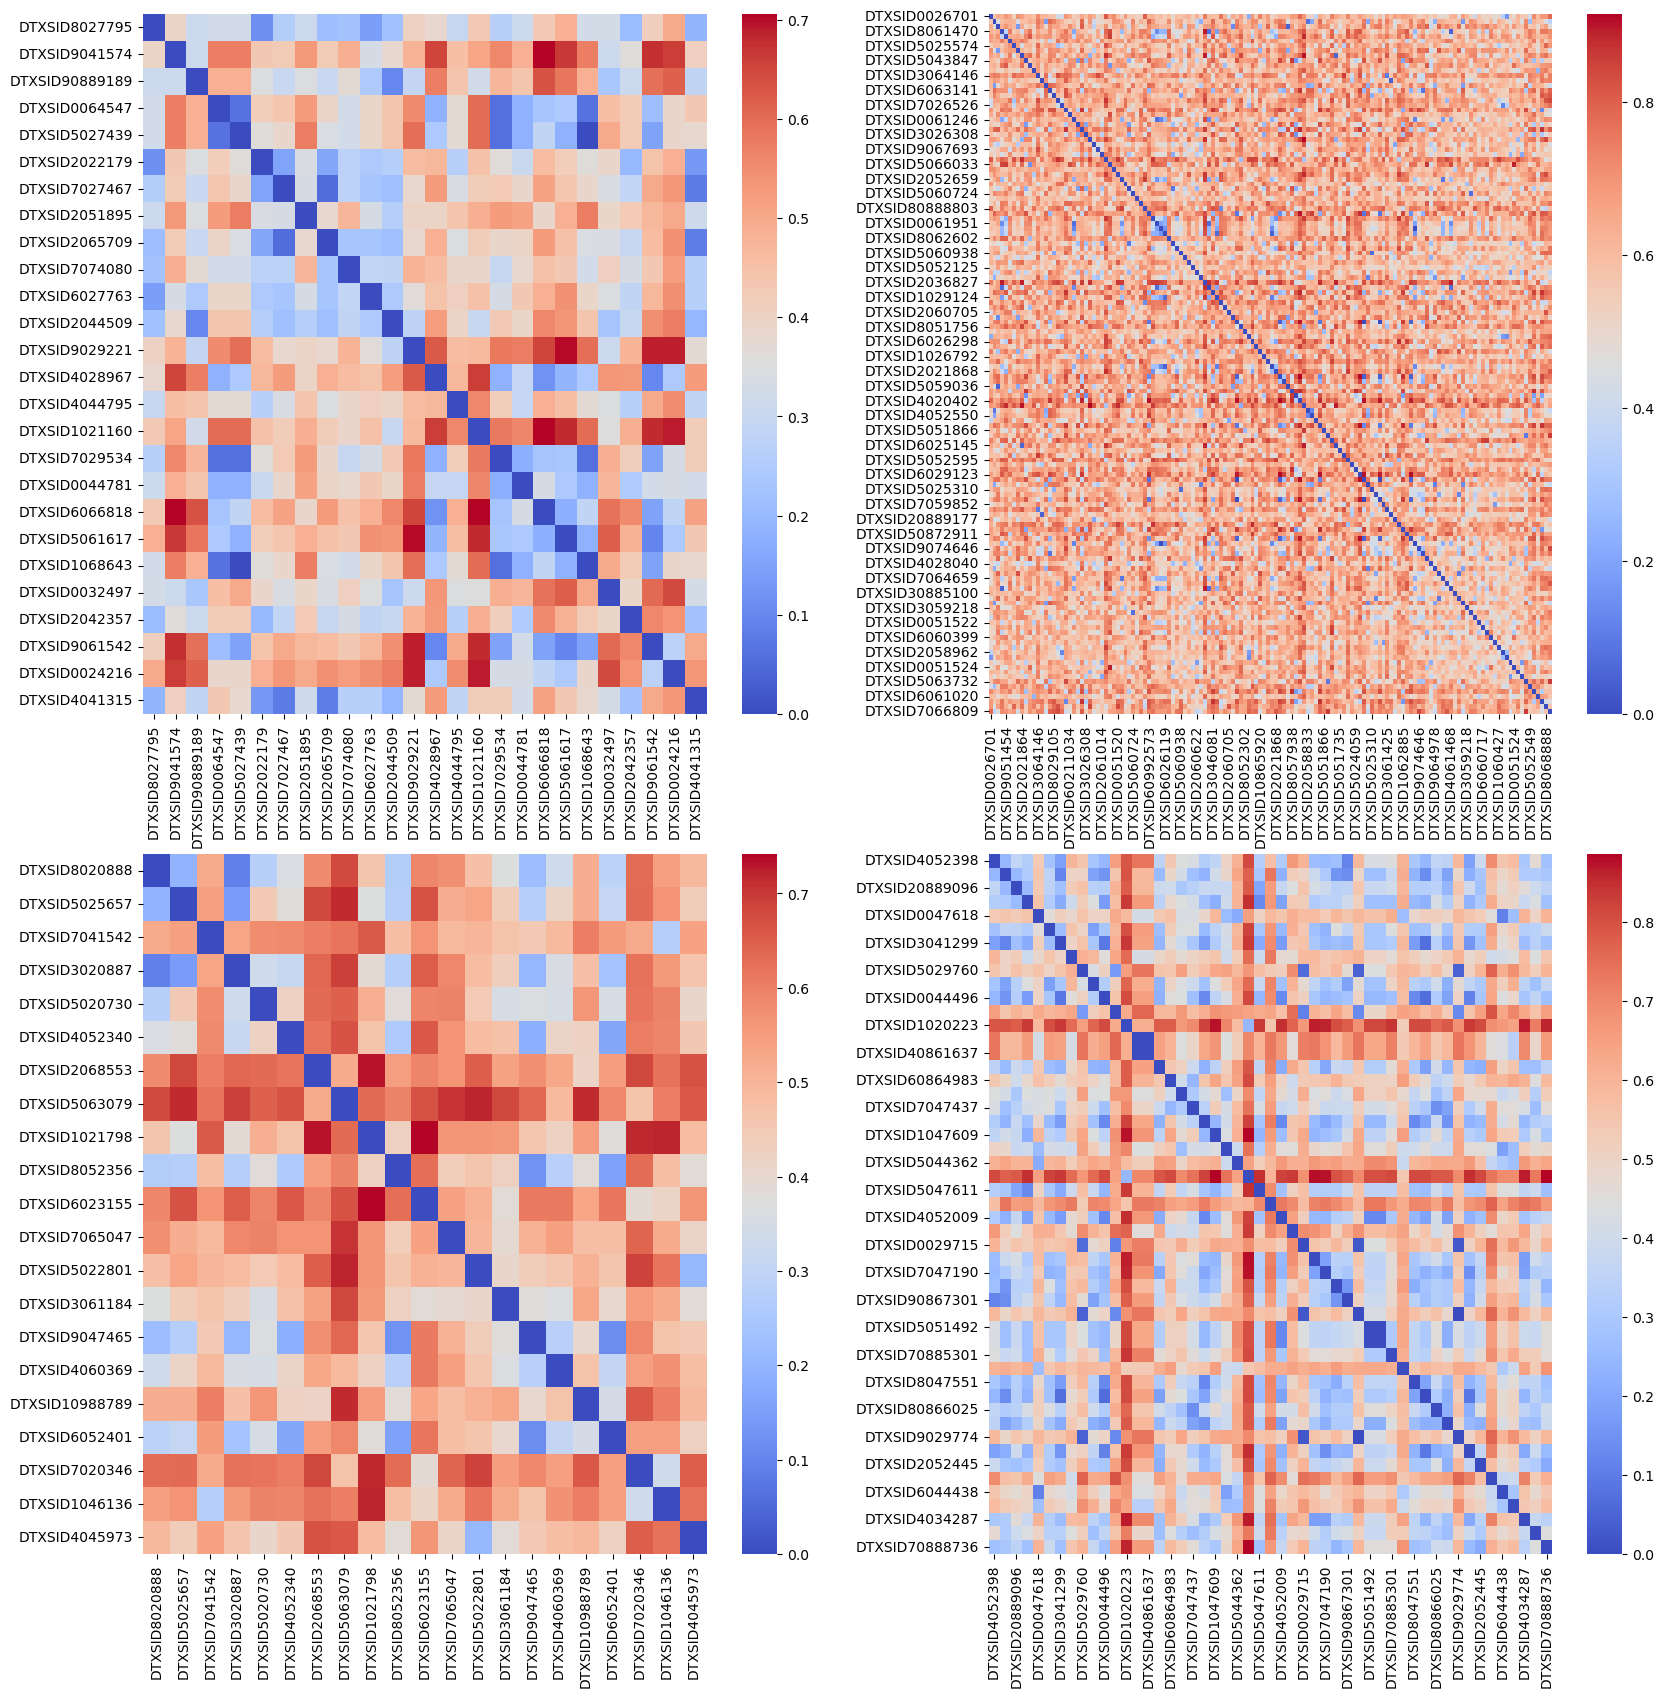

In [189]:
f, ax = plt.subplots(2,2, figsize = (20,20))
sns.heatmap(dists["('Pyridines and derivatives', 1.0)"], cmap = 'coolwarm', ax = ax[0,0])
sns.heatmap(dists["('Benzene and substituted derivatives', 9.0)"], cmap = 'coolwarm', ax = ax[0,1])
sns.heatmap(dists["('Quinolines and derivatives', 3.0)"], cmap = 'coolwarm', ax = ax[1,0])
sns.heatmap(dists["('Lactones', nan)"], cmap = 'coolwarm', ax = ax[1,1])
f.savefig(figures_dir+'figs3.png', dpi = 300)

In [190]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
linkage = hc.linkage(sp.distance.squareform(dists["('Pyridines and derivatives', 1.0)"]), method='ward')

In [278]:
test = dists["('Pyridines and derivatives', 1.0)"] 

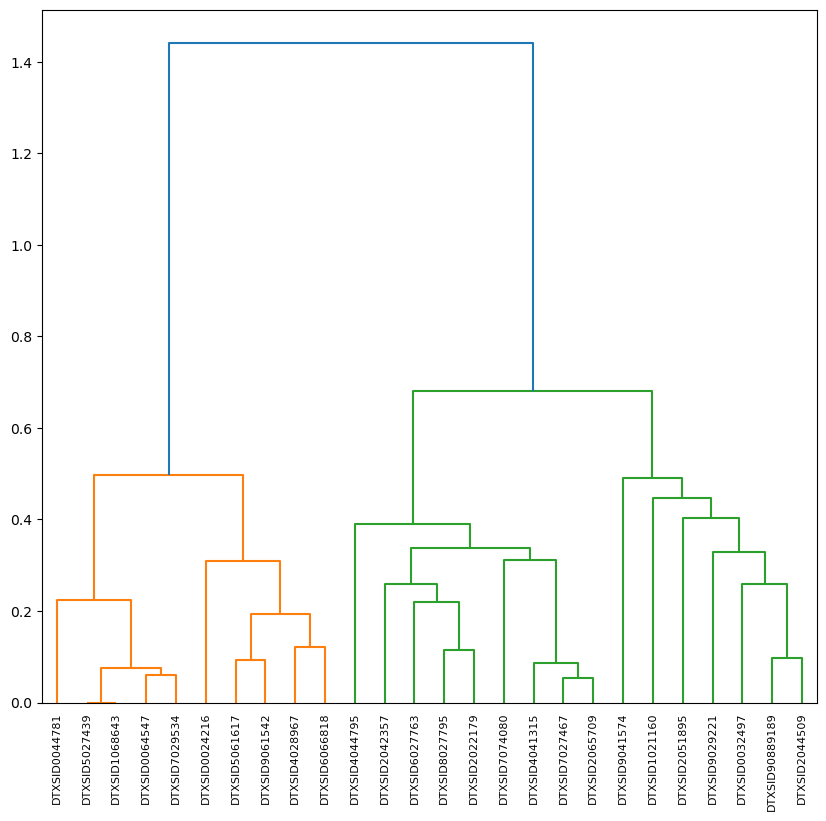

In [279]:
plt.figure(figsize=(10, 9))
dendrogram(
    linkage,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = test.index# font size for the x axis labels
)
plt.show()

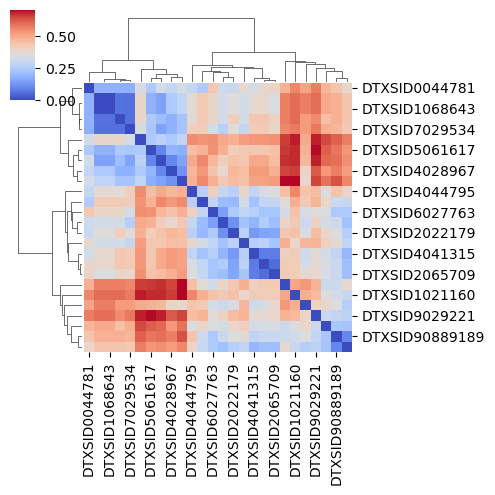

In [280]:
g = sns.clustermap(dists["('Pyridines and derivatives', 1.0)"], row_linkage=linkage, col_linkage=linkage, cmap = 'coolwarm', figsize = (5,5))

In [281]:
from scipy.cluster.hierarchy import fcluster

In [282]:
fcluster(linkage, t=0.6, criterion='distance')

array([2, 3, 3, 1, 1, 2, 2, 3, 2, 2, 2, 3, 3, 1, 2, 3, 1, 1, 1, 1, 1, 3,
       2, 1, 1, 2], dtype=int32)

In [283]:
clusters = pd.DataFrame(list(zip(test.index, fcluster(linkage, t=0.6, criterion='distance'))), columns = ['dtxsid', 'cluster_d'])

In [284]:
clusters = clusters.sort_values(by= 'cluster_d', ascending = True)

In [285]:
clusters_df = pd.merge(results["('Pyridines and derivatives', 1.0)"], clusters, left_on = results["('Pyridines and derivatives', 1.0)"].index, right_on = 'dtxsid', how = 'left')

In [286]:
#clusters_df

In [287]:
clusters_df.to_csv(interim_dir+'vega_pyridines_deriv_091124.csv')

In [288]:
#clusters_df.cluster_d

In [289]:
cluster_profile = (clusters_df
 .set_index('dtxsid')
 .groupby('cluster_d').mean()
)

In [290]:
top_n = 5  # Number of top features to display
for cluster in cluster_profile.index:
    print(f"\nCluster {cluster}:")
    # Use absolute values to find highest confidence features, then display actual signed values
    top_features = cluster_profile.loc[cluster].drop('cluster_d', errors='ignore').abs().nlargest(top_n).index
    print(f"Top {top_n} features (with confidence and effect):")
    for feature in top_features:
        print(f"  {feature}: {cluster_profile.loc[cluster, feature]:.2f}")


Cluster 1:
Top 5 features (with confidence and effect):
  ames_mutagenicity: 0.75
  Eye Irritation (CONCERT/Kode)-assessment: -0.50
  Eye Irritation (CONCERT/SarPy)-assessment: -0.50
  In vivo Micronucleus activity (IRFMN)-assessment: -0.50
  Carcinogenicity inhalation classification model (IRFMN)-assessment: -0.47

Cluster 2:
Top 5 features (with confidence and effect):
  Skin Sensitization model (TOXTREE)-assessment: 0.75
  ames_mutagenicity: -0.75
  Carcinogenicity inhalation classification model (IRFMN)-assessment: -0.56
  In vivo Micronucleus activity (IRFMN)-assessment: -0.56
  Carcinogenicity model (IRFMN-ISSCAN-CGX)-assessment: 0.53

Cluster 3:
Top 5 features (with confidence and effect):
  In vivo Micronucleus activity (IRFMN)-assessment: -0.86
  ames_mutagenicity: -0.75
  Carcinogenicity model (CAESAR)-assessment: -0.68
  Carcinogenicity model (IRFMN-Antares)-assessment: -0.68
  Carcinogenicity inhalation classification model (IRFMN)-assessment: -0.61


In [291]:
from scipy.stats import kruskal

# Identify significant features across clusters using Kruskal-Wallis test

significant_features = []
alpha = 0.05

# Iterate over features and test for differences across clusters
for feature in clusters_df.set_index('dtxsid').columns[:-1]:  # Exclude 'Cluster' column
    # Extract groups by cluster
    groups = [group[feature].dropna() for name, group in clusters_df.set_index('dtxsid').groupby('cluster_d')]
    
    # Check if all values across clusters are identical
    has_variability = any(g.std() > 0 for g in groups)  # Check for at least one non-zero standard deviation
    
    if not has_variability:
        print(f"Skipping {feature} - no variability within clusters")
        continue  # Skip this feature
   
    
    try:
        stat, p = kruskal(*groups)
        if p < alpha:
            significant_features.append(feature)
    except ValueError as e:
        print(f"Skipping {feature} due to error: {e}")

print("Significant features across clusters (signed confidence scores):", significant_features)

Skipping Skin Irritation (CONCERT/Kode)-assessment - no variability within clusters
Skipping ames_mutagenicity - no variability within clusters
Significant features across clusters (signed confidence scores): ['Developmental Toxicity model (CAESAR)-assessment', 'Carcinogenicity model (CAESAR)-assessment', 'Carcinogenicity model (ISS)-assessment', 'Carcinogenicity model (IRFMN-ISSCAN-CGX)-assessment', 'Carcinogenicity model (IRFMN-Antares)-assessment', 'Skin Sensitization model (NCSTOX)-assessment', 'Skin Sensitization model (TOXTREE)-assessment', 'Skin Irritation (CONCERT/Coral)-assessment', 'Skin Irritation model (CONCERT/SarPy)-assessment', 'In vivo Micronucleus activity (IRFMN)-assessment', 'Hepatotoxicity model (IRFMN)-assessment']


In [292]:
len(significant_features)

11

In [293]:
mols = {k:v for k,v in zip(df['dtxsid'], df['smiles'])}
clusters_df['SMILES'] = clusters_df['dtxsid'].apply(lambda x: mols[x])

In [294]:
#clusters_df

In [295]:
mols_cluster_1 = [Chem.MolFromSmiles(e) for e in clusters_df[clusters_df['cluster_d'] == 1]['SMILES']]
mols_cluster_2 = [Chem.MolFromSmiles(e) for e in clusters_df[clusters_df['cluster_d'] == 2]['SMILES']]
mols_cluster_3 = [Chem.MolFromSmiles(e) for e in clusters_df[clusters_df['cluster_d'] == 3]['SMILES']]

In [296]:
from rdkit.Chem.Draw import MolsToGridImage
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
import io

Draw.MolsToGridImage(mols_cluster_1)


img_cluster_1 = Draw.MolsToGridImage(mols_cluster_1) 
img_cluster_2 = Draw.MolsToGridImage(mols_cluster_2) 
png1 = img_cluster_1.data
png2 = img_cluster_2.data

with open(figures_dir+'img_cluster_1.png','wb+') as outf:
    outf.write(png1)
with open(figures_dir+'img_cluster_2.png','wb+') as outf:
    outf.write(png2)
   

In [297]:
linkage_c = hc.linkage(sp.distance.squareform(dists["('Quinolines and derivatives', 3.0)"]), method='ward')

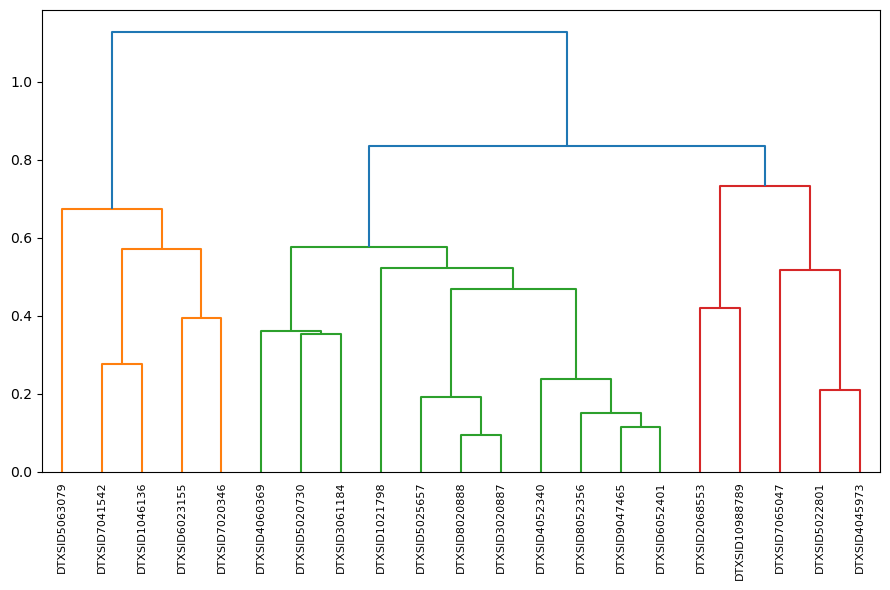

In [298]:
plt.figure(figsize=(9, 6))
dendrogram(
    linkage_c,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = dists["('Quinolines and derivatives', 3.0)"].index# font size for the x axis labels
)
plt.tight_layout()
plt.savefig(figures_dir+'fig7.png', dpi=300);

In [299]:
clusters_c = pd.DataFrame(list(zip(dists["('Quinolines and derivatives', 3.0)"].index, fcluster(linkage_c, t=0.75, criterion='distance'))), columns = ['dtxsid', 'cluster_d'])

In [300]:
clusters_c_df = pd.merge(results["('Quinolines and derivatives', 3.0)"], clusters_c, left_on = results["('Quinolines and derivatives', 3.0)"].index, right_on = 'dtxsid', how = 'left')


In [301]:
clusters_c_df.to_csv(interim_dir+'vega_quinolines_derivs_091124.csv')

In [302]:
cluster_profile2 = (clusters_c_df
 .set_index('dtxsid')
 .groupby('cluster_d').mean()
)

In [303]:
top_n = 5  # Number of top features to display
for cluster in cluster_profile2.index:
    print(f"\nCluster {cluster}:")
    # Use absolute values to find highest confidence features, then display actual signed values
    top_features = cluster_profile2.loc[cluster].drop('cluster_d', errors='ignore').abs().nlargest(top_n).index
    print(f"Top {top_n} features (with confidence and effect):")
    for feature in top_features:
        print(f"  {feature}: {cluster_profile2.loc[cluster, feature]:.2f}")


Cluster 1:
Top 5 features (with confidence and effect):
  ames_mutagenicity: 0.45
  Developmental Toxicity model (CAESAR)-assessment: 0.40
  Hepatotoxicity model (IRFMN)-assessment: 0.40
  Carcinogenicity model (IRFMN-ISSCAN-CGX)-assessment: 0.35
  Skin Sensitization model (IRFMN-JRC)-assessment: 0.35

Cluster 2:
Top 5 features (with confidence and effect):
  Carcinogenicity model (IRFMN-Antares)-assessment: -0.82
  Carcinogenicity oral classification model (IRFMN)-assessment: 0.77
  In vitro Micronucleus activity (IRFMN-VERMEER)-assessment: 0.75
  Skin Sensitization model (CAESAR)-assessment: 0.70
  Skin Sensitization model (NCSTOX)-assessment: 0.61

Cluster 3:
Top 5 features (with confidence and effect):
  ames_mutagenicity: -0.75
  Carcinogenicity oral classification model (IRFMN)-assessment: 0.60
  Hepatotoxicity model (IRFMN)-assessment: 0.60
  In vivo Micronucleus activity (IRFMN)-assessment: -0.58
  Carcinogenicity model (IRFMN-Antares)-assessment: -0.50


In [304]:
significant_features = []
alpha = 0.05

# Iterate over features and test for differences across clusters
for feature in clusters_c_df.set_index('dtxsid').columns[:-1]:  # Exclude 'Cluster' column
    # Extract groups by cluster
    groups = [group[feature].dropna() for name, group in clusters_c_df.set_index('dtxsid').groupby('cluster_d')]
    
    # Check if all values across clusters are identical
    has_variability = any(g.std() > 0 for g in groups)  # Check for at least one non-zero standard deviation
    
    if not has_variability:
        print(f"Skipping {feature} - no variability within clusters")
        continue  # Skip this feature
   
    
    try:
        stat, p = kruskal(*groups)
        if p < alpha:
            significant_features.append(feature)
    except ValueError as e:
        print(f"Skipping {feature} due to error: {e}")

print("Significant features across clusters (signed confidence scores):", significant_features)

Skipping Skin Irritation (CONCERT/Kode)-assessment - no variability within clusters
Significant features across clusters (signed confidence scores): ['Carcinogenicity model (IRFMN-ISSCAN-CGX)-assessment', 'Carcinogenicity model (IRFMN-Antares)-assessment', 'Carcinogenicity oral classification model (IRFMN)-assessment', 'Skin Sensitization model (CAESAR)-assessment', 'Skin Sensitization model (IRFMN-JRC)-assessment', 'Skin Sensitization model (NCSTOX)-assessment', 'In vitro Micronucleus activity (IRFMN-VERMEER)-assessment', 'ames_mutagenicity']


In [305]:
len(significant_features)

8

In [306]:
[e for e in df.group_str.unique().tolist() if e not in results.keys()]

[nan, "('Nucleosides, nucleotides, and analogues', nan)"]

In [307]:
def clust_output(d, r, label = None):
    link = hc.linkage(sp.distance.squareform(d[label]), method='ward')
    clust = pd.DataFrame(list(zip(dists[label].index, fcluster(link, t=0.7, criterion='distance'))), columns = ['dtxsid', 'cluster_d'])
    clust_df = pd.merge(r[label], clust, left_on = r[label].index, right_on = 'dtxsid', how = 'left')
    clust_df.set_index('dtxsid')
    return clust_df
    

In [357]:
def clust_out(clust_df, label = None):
    top_n = 3
    clust_profile = clust_df.groupby('cluster_d').mean()
    alerts = {}
    
    for cluster in clust_profile.index:
        #print(f"\nCluster {cluster}:")
        top_features = clust_profile.loc[cluster].drop('cluster_d', errors='ignore').abs().nlargest(top_n).index
        alert_lst = []
        for feature in top_features:
            #print(f"  {feature}: {clust_profile.loc[cluster, feature]:.2f}")
              alert_lst.append((feature, clust_profile.loc[cluster, feature]))
        alerts[cluster]= alert_lst
    return   alerts

In [310]:
summaries = {}
for e in results.keys():
    try:
        summaries[e] = clust_output(dists, results, label = e)
    except Exception as error:
        print(e)

('Lipids and lipid-like molecules', nan)


In [316]:
test2 = summaries["('Quinolines and derivatives', 3.0)"]

In [359]:
alert_dict = {}
for e in summaries.keys():
    alert_dict[e] = clust_out(summaries[e])

/tmp/ipykernel_1999839/2980117478.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  clust_profile = clust_df.groupby('cluster_d').mean()
/tmp/ipykernel_1999839/2980117478.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  clust_profile = clust_df.groupby('cluster_d').mean()
/tmp/ipykernel_1999839/2980117478.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  clust_profile = clust_df.groupby('cluster_d').mean()
/tmp

In [361]:
alert_dict["('Acetylides', nan)"]

{1: [('In vivo Micronucleus activity (IRFMN)-assessment', -0.6071428571428571),
  ('ames_mutagenicity', 0.5625),
  ('Eye Irritation (CONCERT/SarPy)-assessment', -0.5)],
 2: [('ames_mutagenicity', -0.75),
  ('Chromosomal aberration model (CORAL)-assessment', -0.39285714285714285),
  ('Carcinogenicity oral classification model (IRFMN)-assessment',
   -0.32142857142857145)],
 3: [('Eye Irritation (CONCERT/KNN)-assessment', -0.75),
  ('Eye Irritation (CONCERT/SarPy)-assessment', -0.75),
  ('ames_mutagenicity', -0.75)],
 4: [('Carcinogenicity inhalation classification model (IRFMN)-assessment',
   -0.75),
  ('ames_mutagenicity', -0.75),
  ('Chromosomal aberration model (CORAL)-assessment', -0.5)]}

In [370]:
len({k:len([e for e in v]) for k,v in alert_dict.items() if len([e for e in v]) ==1})

19

In [371]:
{k:len([e for e in v]) for k,v in alert_dict.items() if len([e for e in v]) ==1}

{"('Alkaloids and derivatives', nan)": 1,
 "('Allenes', nan)": 1,
 "('Azobenzenes', 1.0)": 1,
 "('Azobenzenes', 5.0)": 1,
 "('Azoles', 3.0)": 1,
 "('Azolidines', 1.0)": 1,
 "('Homogeneous metal compounds', nan)": 1,
 "('Homogeneous non-metal compounds', 1.0)": 1,
 "('Inorganic salts', nan)": 1,
 "('Lignans, neolignans and related compounds', nan)": 1,
 "('Miscellaneous inorganic compounds', nan)": 1,
 "('Mixed metal/non-metal compounds', 1.0)": 1,
 "('Mixed metal/non-metal compounds', 3.0)": 1,
 "('Mixed metal/non-metal compounds', 4.0)": 1,
 "('Organic oxygen compounds', nan)": 1,
 "('Organoheterocyclic compounds', 2.0)": 1,
 "('Phenylpropanoids and polyketides', 1.0)": 1,
 "('Quinolines and derivatives', 1.0)": 1,
 "('Quinolines and derivatives', 2.0)": 1}

In [375]:
chk_k = []
for k, v in alert_dict.items():
    if len([e for e in v]) ==1 and results[k].shape[0] >5:
        print(k, results[k].shape)
        chk_k.append(k)

('Azobenzenes', 1.0) (6, 25)
('Azobenzenes', 5.0) (13, 25)
('Homogeneous metal compounds', nan) (56, 25)
('Homogeneous non-metal compounds', 1.0) (10, 25)
('Mixed metal/non-metal compounds', 1.0) (57, 25)
('Mixed metal/non-metal compounds', 3.0) (41, 25)
('Mixed metal/non-metal compounds', 4.0) (31, 25)
('Organic oxygen compounds', nan) (6, 25)
('Organoheterocyclic compounds', 2.0) (12, 25)
('Phenylpropanoids and polyketides', 1.0) (12, 25)
('Quinolines and derivatives', 1.0) (6, 25)
('Quinolines and derivatives', 2.0) (11, 25)


In [381]:
for k,v in alert_dict.items():
    if k in chk_k:
        print(k, alert_dict[k])

('Azobenzenes', 1.0) {1: [('Skin Sensitization model (TOXTREE)-assessment', 0.75), ('ames_mutagenicity', 0.75), ('Eye Irritation (CONCERT/SarPy)-assessment', -0.6875)]}
('Azobenzenes', 5.0) {1: [('ames_mutagenicity', 0.75), ('Carcinogenicity oral classification model (IRFMN)-assessment', -0.6923076923076923), ('Skin Sensitization model (TOXTREE)-assessment', 0.6730769230769231)]}
('Homogeneous metal compounds', nan) {1: [('ames_mutagenicity', -0.75), ('Developmental Toxicity model (CAESAR)-assessment', -0.25), ('Carcinogenicity model (CAESAR)-assessment', 0.25)]}
('Homogeneous non-metal compounds', 1.0) {1: [('Eye Irritation (CONCERT/SarPy)-assessment', 1.0), ('ames_mutagenicity', -0.45), ('Developmental/Reproductive Toxicity library (PG)-assessment', -0.25)]}
('Mixed metal/non-metal compounds', 1.0) {1: [('ames_mutagenicity', -0.7236842105263158), ('Carcinogenicity model (IRFMN-ISSCAN-CGX)-assessment', -0.25), ('Carcinogenicity model (IRFMN-Antares)-assessment', -0.25)]}
('Mixed metal

In [393]:
vega_2 = (vega_1.iloc[:,:-2]
 .applymap(lambda x: 1 if x > 0 else (0 if x < 0 else np.nan))
)

In [412]:
vega_2 = pd.concat([vega_2,vega_1['group_str']],axis =1 )

In [394]:
all_alerts = (vega_2
 .columns[vega_2.eq(1).any()].tolist()[:-1]
)

In [395]:

res =[e.split('model')[0] for e in all_alerts]
    
    

In [396]:
res

['Developmental Toxicity ',
 'Developmental/Reproductive Toxicity library (PG)-assessment',
 'Carcinogenicity ',
 'Carcinogenicity ',
 'Carcinogenicity ',
 'Carcinogenicity ',
 'Carcinogenicity oral classification ',
 'Carcinogenicity inhalation classification ',
 'Skin Sensitization ',
 'Skin Sensitization ',
 'Skin Sensitization ',
 'Skin Sensitization ',
 'Skin Sensitization (CONCERT/Kode)-assessment',
 'Skin Sensitization (CONCERT/SarPy)-assessment',
 'Skin Irritation (CONCERT/Kode)-assessment',
 'Skin Irritation (CONCERT/Coral)-assessment',
 'Skin Irritation ',
 'Eye Irritation (CONCERT/Kode)-assessment',
 'Eye Irritation (CONCERT/KNN)-assessment',
 'Eye Irritation (CONCERT/SarPy)-assessment',
 'Chromosomal aberration ',
 'In vitro Micronucleus activity (IRFMN-VERMEER)-assessment',
 'In vivo Micronucleus activity (IRFMN)-assessment',
 'Hepatotoxicity ']

In [397]:
res1 = []
for e in res:
    if 'CONCERT' in e:
        res1.append(e.split('(CONCERT')[0])
    elif 'CONSENSUS' in e:
        res1.append(e.split('CONSENSUS')[0])
    elif 'IRFMN' in e:
        res1.append(e.split('(IRFMN')[0])
    elif 'library' in e:
        res1.append(e.split('library')[0])
    else:
        res1.append(e)

In [398]:
res1 = [e.strip() for e in res1]

In [399]:
res1 = list(set(res1))

In [400]:
group_str_dict = {k:list(v.index) for k,v in vega_1.groupby('group_str')}

In [401]:
new_df = pd.DataFrame(columns = res1, index = group_str_dict.keys())

In [403]:
new_df.columns

Index(['Carcinogenicity', 'Carcinogenicity inhalation classification',
       'Developmental/Reproductive Toxicity', 'Chromosomal aberration',
       'In vivo Micronucleus activity', 'Hepatotoxicity',
       'In vitro Micronucleus activity', 'Developmental Toxicity',
       'Eye Irritation', 'Skin Sensitization',
       'Carcinogenicity oral classification', 'Skin Irritation'],
      dtype='object')

In [404]:
alert_dict2 = {}
for y in all_alerts:
    for e in res1:
        if e in y:
            alert_dict2[y] = e

In [405]:
reversed_dict = {}
for key, value in alert_dict2.items():
    if value not in reversed_dict:
        reversed_dict[value] = []
    reversed_dict[value].append(key)

In [406]:
alert_dict2

{'Developmental Toxicity model (CAESAR)-assessment': 'Developmental Toxicity',
 'Developmental/Reproductive Toxicity library (PG)-assessment': 'Developmental/Reproductive Toxicity',
 'Carcinogenicity model (CAESAR)-assessment': 'Carcinogenicity',
 'Carcinogenicity model (ISS)-assessment': 'Carcinogenicity',
 'Carcinogenicity model (IRFMN-ISSCAN-CGX)-assessment': 'Carcinogenicity',
 'Carcinogenicity model (IRFMN-Antares)-assessment': 'Carcinogenicity',
 'Carcinogenicity oral classification model (IRFMN)-assessment': 'Carcinogenicity oral classification',
 'Carcinogenicity inhalation classification model (IRFMN)-assessment': 'Carcinogenicity inhalation classification',
 'Skin Sensitization model (CAESAR)-assessment': 'Skin Sensitization',
 'Skin Sensitization model (IRFMN-JRC)-assessment': 'Skin Sensitization',
 'Skin Sensitization model (NCSTOX)-assessment': 'Skin Sensitization',
 'Skin Sensitization model (TOXTREE)-assessment': 'Skin Sensitization',
 'Skin Sensitization (CONCERT/Kode)-

In [413]:
for row in new_df.index:
    for col in new_df.columns:
        a = vega_2[vega_2['group_str'] ==row][reversed_dict[col]].sum(axis = 1).sum()
        new_df.loc[row,col] = a


In [414]:
new_df

,Carcinogenicity,Carcinogenicity inhalation classification,Developmental/Reproductive Toxicity,Chromosomal aberration,In vivo Micronucleus activity,Hepatotoxicity,In vitro Micronucleus activity,Developmental Toxicity,Eye Irritation,Skin Sensitization,Carcinogenicity oral classification,Skin Irritation
"('Acetylides', nan)",67.0,8.0,6.0,1.0,1.0,0.0,1.0,4.0,11.0,106.0,7.0,35.0
"('Alkaloids and derivatives', nan)",2.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,5.0,1.0,3.0
"('Allenes', nan)",2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0
"('Anthracenes', 1.0)",50.0,14.0,6.0,4.0,4.0,2.0,15.0,14.0,3.0,64.0,12.0,1.0
"('Anthracenes', 2.0)",34.0,11.0,0.0,11.0,0.0,0.0,11.0,11.0,8.0,43.0,11.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
"('Quinolines and derivatives', 4.0)",91.0,32.0,3.0,18.0,9.0,38.0,41.0,42.0,18.0,114.0,42.0,3.0
"('Quinolines and derivatives', 5.0)",32.0,6.0,1.0,4.0,0.0,2.0,10.0,13.0,8.0,52.0,14.0,5.0
"('Steroids and steroid derivatives', nan)",15.0,3.0,0.0,1.0,0.0,6.0,0.0,6.0,0.0,21.0,7.0,11.0
"('Triazines', nan)",62.0,10.0,3.0,17.0,10.0,4.0,16.0,31.0,24.0,132.0,23.0,8.0


In [415]:
new_df.to_csv(interim_dir+'vega_map_091124.csv')

<Axes: >

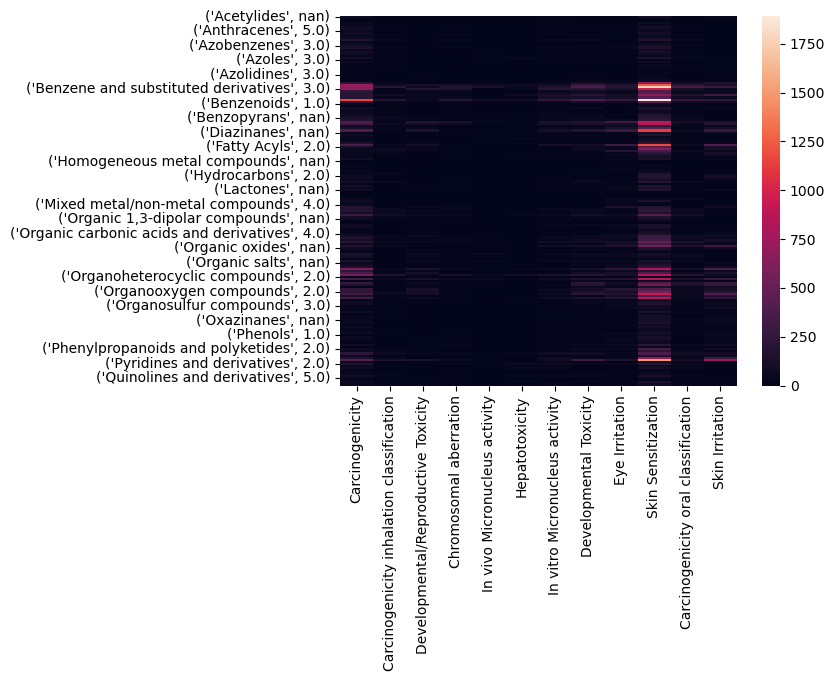

In [416]:
sns.heatmap(new_df.astype(float))

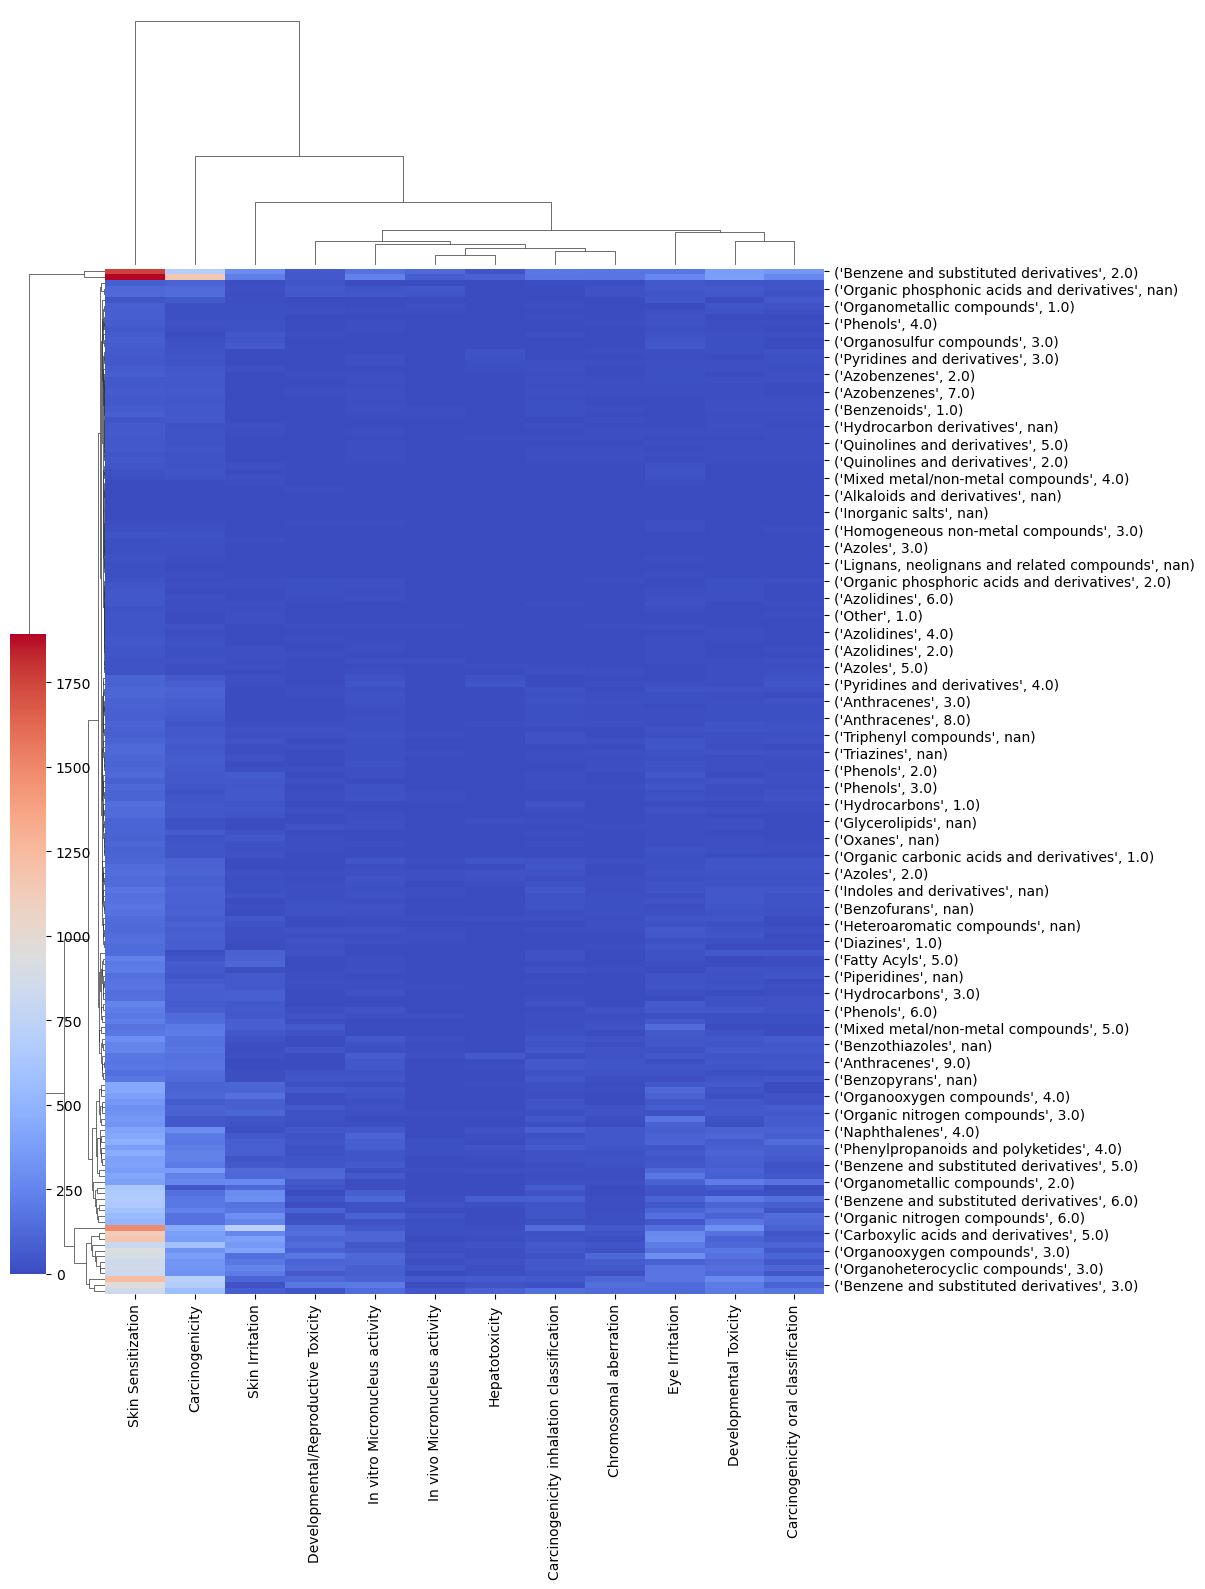

In [417]:
sns.clustermap(new_df.astype(float), 
               cmap='coolwarm',  # Choose the colormap
               figsize=(12,16),  # Figure size
               row_cluster=True,  # Cluster rows
               col_cluster=True,  # Cluster columns
               dendrogram_ratio=(.1, .2),  # Adjust the ratio of dendrogram height
               #linewidths=0.5,  # Width of lines dividing each cell
              # linecolor='grey',  # Color of lines dividing each cell
               cbar_pos=(0, .2, .03, .4),  # Position of colorbar
               # Label for colorbar
               method='average') 

In [418]:
most_endpoints = {}
for col in new_df.columns:
    a = new_df[new_df[col] >50].index
    if len(a) >=1:
        most_endpoints[col] = a

In [420]:
#most_endpoints

In [308]:
{k:len(v) for k,v in most_endpoints.items()}

{'Carcinogenicity inhalation classification': 13,
 'Skin Sensitization': 141,
 'Eye Irritation': 38,
 'In vivo Micronucleus activity': 3,
 'In vitro Micronucleus activity': 24,
 'Carcinogenicity': 104,
 'Mutagenicity (Ames test)': 11,
 'Skin Irritation': 52,
 'Developmental/Reproductive Toxicity': 21,
 'Developmental Toxicity': 37,
 'Carcinogenicity oral classification': 33,
 'Hepatotoxicity': 5}

In [421]:
top_cats = pd.DataFrame(list(most_endpoints.items()))
top_cat = top_cats.explode(1)

# Explode the 'Values' column
top_cat.columns = ['Endpoint', 'Terminal_Category']
top_cat

,Endpoint,Terminal_Category
0,Carcinogenicity,"('Acetylides', nan)"
0,Carcinogenicity,"('Anthracenes', 3.0)"
0,Carcinogenicity,"('Anthracenes', 4.0)"
0,Carcinogenicity,"('Anthracenes', 5.0)"
0,Carcinogenicity,"('Anthracenes', 6.0)"
...,...,...
11,Skin Irritation,"('Phenylpropanoids and polyketides', 2.0)"
11,Skin Irritation,"('Phenylpropanoids and polyketides', 4.0)"
11,Skin Irritation,"('Piperidines', nan)"
11,Skin Irritation,"('Prenol lipids', 1.0)"


In [422]:
top_cat

,Endpoint,Terminal_Category
0,Carcinogenicity,"('Acetylides', nan)"
0,Carcinogenicity,"('Anthracenes', 3.0)"
0,Carcinogenicity,"('Anthracenes', 4.0)"
0,Carcinogenicity,"('Anthracenes', 5.0)"
0,Carcinogenicity,"('Anthracenes', 6.0)"
...,...,...
11,Skin Irritation,"('Phenylpropanoids and polyketides', 2.0)"
11,Skin Irritation,"('Phenylpropanoids and polyketides', 4.0)"
11,Skin Irritation,"('Piperidines', nan)"
11,Skin Irritation,"('Prenol lipids', 1.0)"


In [423]:
import networkx as nx
import matplotlib.pyplot as plt 
import ast

In [424]:
import re

def extract_alpha(text):
    return re.sub(r'[^a-zA-Z]', ' ', text)

In [425]:
top_cat['Category']= top_cat['Terminal_Category'].apply(lambda x: extract_alpha(x))

In [426]:
top_cat['Category'] = [e.strip(' ').replace('nan','').rstrip(' ')  for e in top_cat['Category']]

In [427]:
mydict2 = {k:v for k,v in zip(set(top_cat['Category']), set(top_cat['Category']))}

In [428]:
mydict2 = {'Organosulfur compounds': 'Organosulfur',
 'Benzothiazoles': 'Benzothiazoles',
 'Ligs  neoligs and related compounds': 'Ligs/neoligs',
 'Lipids and lipid like molecules': 'Lipids and lipid like',
 'Pyridines and derivatives': 'Pyridine deriv',
 'Organic oxygen compounds': 'Organic oxygen',
 'Naphthalenes': 'Naphthalenes',
 'Piperidines': 'Piperidines',
 'Phenol ethers': 'Phenol ethers',
 'Anthracenes': 'Anthracenes',
 'Nucleosides  nucleotides  and analogues': 'Nucleosides/nucleotides',
 'Allenes': 'Allenes',
 'Keto acids and derivatives': 'Keto acid deriv',
 'Benzenoids': 'Benzenoids',
 'Mixed metal non metal compounds': 'Mixed metal/non metal',
 'Organometallic compounds': 'Organometallic compounds',
 'Organic carbonic acids and derivatives': 'Organic carbonic acid deriv',
 'Phenols': 'Phenols',
 'Benzimidazoles': 'Benzimidazoles',
 'Organic salts': 'Organic salts',
 'Organic acids and derivatives': 'Organic acid deriv',
 'Diazies': 'Diazies',
 'Organic oxoanionic compounds': 'Organic oxoanionic',
 'Steroids and steroid derivatives': 'Steroid deriv',
 'Azobenzenes': 'Azobenzenes',
 'Carboxylic acids and derivatives': 'COOH deriv',
 'Organic     dipolar compounds': 'Organic dipolar',
 'Indanes': 'Indanes',
 'Hydrocarbons': 'Hydrocarbons',
 'Epoxides': 'Epoxides',
 'Diazines': 'Diazines',
 'Organohalogen compounds': 'Organohalogen',
 'Acetylides': 'Acetylides',
 'Triazines': 'Triazines',
 'Homogeneous non metal compounds': 'Homogeneous non metal',
 'Benzene and substituted derivatives': 'Benzene substituted deriv',
 'Alkaloids and derivatives': 'Alkaloid deriv',
 'Quinolines and derivatives': 'Quinolines deriv',
 'Glycerolipids': 'Glycerolipids',
 'Azolidines': 'Azolidines',
 'Hydrocarbon derivatives': 'Hydrocarbons',
 'Phenol esters': 'Phenol esters',
 'Oxazies': 'Oxazies',
 'Prenol lipids': 'Prenol lipids',
 'Oxanes': 'Oxanes',
 'Fatty Acyls': 'Fatty Acyls',
 'Organoheterocyclic compounds': 'Organoheterocyclic',
 'Indoles and derivatives': 'Indoles deriv',
 'Organic oxides': 'Organic oxides',
 'Triphenyl compounds': 'Triphenyl',
 'Azoles': 'Azoles',
 'Organic nitrogen compounds': 'Organic nitrogen',
 'Phenylpropanoids and polyketides': 'Phenylpropanoids and polyketides',
 'Dioxanes': 'Dioxanes',
 'Organic phosphonic acids and derivatives': 'Organic phosphonic acids deriv',
 'Organic sulfonic acids and derivatives': 'Organic sulfonic acids deriv',
 'Benzofurans': 'Benzofurans',
 'Heteroaromatic compounds': 'Heteroaromatic',
 'Benzopyrans': 'Benzopyrans',
 'Lactones': 'Lactones',
 'Other': 'Other',
 'Organic phosphoric acids and derivatives': 'Organic phosphoric acid  deriv',
 'Organophosphorus compounds': 'Organophosphorus',
 'Isoindoles and derivatives': 'Isoindoles deriv',
 'Organooxygen compounds': 'Organooxygen'}

In [429]:
top_cat['Category2'] = top_cat['Category'].replace(mydict2)

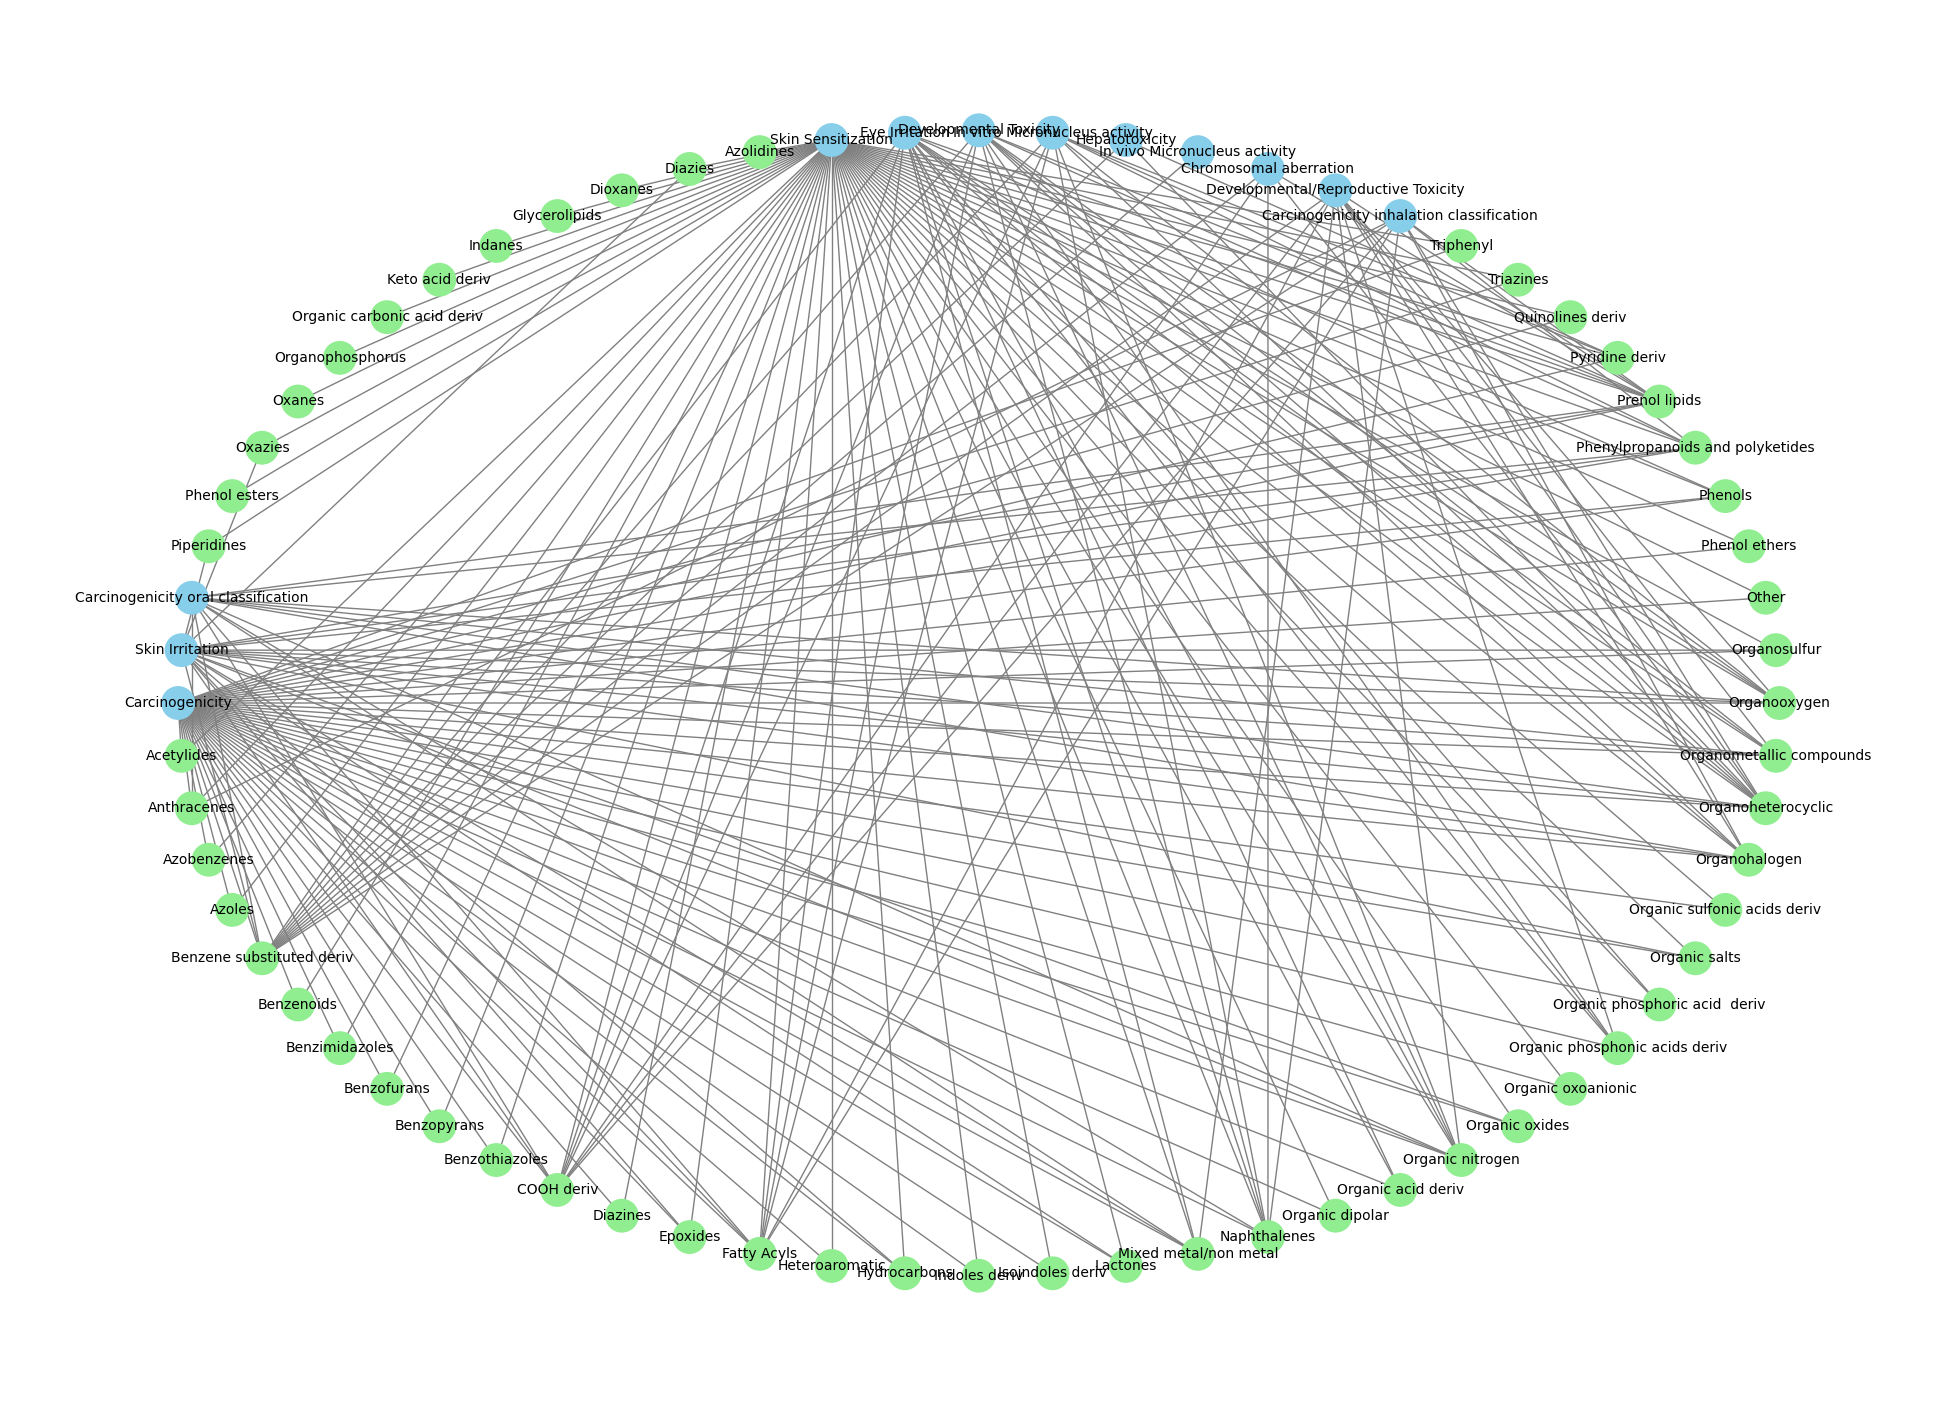

In [430]:
G = nx.from_pandas_edgelist(top_cat, 'Endpoint', 'Category2')
assays = top_cat['Endpoint'].unique()
terminal_categories = top_cat['Category2'].unique()
pos = nx.shell_layout(G)
pos2 = nx.kamada_kawai_layout(G)
# Create a new figure and axis
fig, ax = plt.subplots(figsize = (25,18))

# Position nodes using Fruchterman-Reingold force-directed algorithm
#pos = nx.spring_layout(G)
node_color = ['skyblue' if node in assays else 'lightgreen' for node in G.nodes]

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_color, font_size=10,  edge_color='gray', linewidths=2, arrowsize=20, ax=ax)

# Show the plot
plt.show()
fig.savefig(figures_dir+'vega_nx.png', dpi = 300);